In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import math
import itertools as itool
import time

In [2]:
class BoundaryCondition:
    RBC, PBC = range(2)
    
class StartConf:
    Triangular, Rectangular, Random, Confined = range(4)

In [3]:
class particle2(object):

    def __init__(self, mass=1., x=0., y=0., vx=0., vy=0.):
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.fx = 0.
        self.fy = 0.
       
    def euler(self, fx, fy, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        self.x = self.x + self.vx*dt
        self.y = self.y + self.vy*dt
        
    def accel(self, dt):                                # Pushes velocity ahead one timestep
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        
    def move(self, dt, dt2half):                                 # pushes position ahead one timestep
        self.x = self.x + self.vx*dt + self.fx/self.mass*dt2half
        self.y = self.y + self.vy*dt + self.fy/self.mass*dt2half

In [4]:
class MDsystem(object):

    def __init__(self, lx, ly, N, dt, bc): 
        self.N = N
        self.lx = lx
        self.ly = ly
        self.dt = dt
        self.dt2 = dt*dt
        self.dthalf = dt * 0.5
        self.dt2half = self.dt2 * 0.5
        self.bc = bc
        self.particles = [particle2()]
        for i in range(1,N):
            self.particles.append(particle2()) # we create a list of N particles

    def init(self, config, vmax):
        np.random.seed(1272121) # arbitrary seed
        nrows = int(math.sqrt(self.N)*float(self.ly)/float(self.lx))
        ncols = int(math.sqrt(self.N)*float(self.lx)/float(self.ly))
        ax = float(self.lx) / float(ncols)
        ay = float(self.ly) / float(nrows)
        i = 0

        if config == StartConf.Triangular:
            #Challenge
            nrows = int(math.sqrt(self.N))
            ncols = int(nrows)
            ax = float(self.lx)/float(ncols)
            ay = float(self.ly)/float(nrows)
            for row, col in itool.product(range(nrows),range(ncols)):
                self.particles[i].x = col*ax+ax/2.
                if row%2 == 1:
                    self.particles[i].x += ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1
        elif config == StartConf.Rectangular:
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1

            for row, col in itool.product(range(1,nrows),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.+ax/4.
                self.particles[i].y = row*ay+ay/2.+ay/4.
                i+=1
                
        elif config == StartConf.Confined:
            ax /= 2.
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1

            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.+ax/4.
                self.particles[i].y = row*ay+ay/2.+ay/4.
                i+=1
                
        elif config == StartConf.Random:
            for i in range(self.N):
                overlap = True;
                while overlap:
                    overlap = False;
                    self.particles[i].x = np.random.random()*self.lx
                    self.particles[i].y = np.random.random()*self.ly
                    for j in range(i):
                        r12 = self.distance(self.particle[i], self.particle.p[j])
                        if r12 < 1.: 
                            overlap = True;
                            break
                                
        # Velocities
        for p in self.particles:
            p.vx = vmax*(2. * np.random.random() - 1);
            p.vy = vmax*(2. * np.random.random() - 1);

        # We set total momentum to zero
        vxcm = 0.
        vycm = 0. # Velocity of the center of mass
        for p in self.particles:
            vxcm += p.vx;
            vycm += p.vy;
        
        vxcm /= self.N
        vycm /= self.N
        for p in self.particles:
            p.vx -= vxcm;
            p.vy -= vycm;
            
        self.forces()          
        
    def evolve(self):
        for p in self.particles:
            p.move(self.dt, self.dt2half)
            p.accel(self.dthalf)
            self.boundary(p)

        self.forces()

        for p in self.particles:
            p.accel(self.dthalf)

        
    def distance(self, p, other):
        (r12, dx, dy) = self.distance2(p, other)
        return math.sqrt(r12)

    def distance2(self, p, other):
        dx = other.x - p.x;
        dy = other.y - p.y;


        # nearest image convention
        if self.bc == BoundaryCondition.PBC:
            if abs(dx) > self.lx/2:
                dx -= dx*self.lx/abs(dx)
                
            if abs(dy) > self.ly/2:
                dy -= dy*self.ly/abs(dy)
        
        r12 = dx * dx + dy * dy
        return (r12, dx, dy)

    def force(self, p, other):  #Lennard-Jones
        (r12,dx,dy) = self.distance2(p, other)
        r2 = 1./r12
        r6 = r2 * r2 * r2
        f = 24.*r2*r6*(2.*r6-1.)
        fx = f*(-dx)
        fy = f*(-dy)
        return (fx, fy);
      
    def forces(self):
        # Compute the interaction forces between particles
        for p in self.particles:
            p.fx = 0.
            p.fy = 0.
    
        for i in range(self.N):
            p = self.particles[i]
            for j in range(i+1,self.N):
                other = self.particles[j]
                (fx, fy) = self.force(p, other)
                p.fx += fx
                p.fy += fy
                other.fx -= fx
                other.fy -= fy

    def boundary(self, p):
        if self.bc == BoundaryCondition.RBC:
            
            if p.x < 0:  
                p.x = -p.x
                p.vx = -p.vx
            if p.y < 0:
                p.y = -p.y
                p.vy = -p.vy
            if p.x > self.lx:
                p.x = 2*self.lx - p.x
                p.vx = -p.vx
            if p.y > self.ly:
                p.y = 2*self.ly - p.y
                p.vy = -p.vy

        elif self.bc == BoundaryCondition.PBC:

            if p.x < 0: 
                p.x += self.lx
            elif p.x > self.lx:  
                p.x -= self.lx
            if p.y < 0:  
                p.y += self.ly
            elif p.y > self.ly:  
                p.y -= self.ly
#            c = (p.x+2*self.lx)/self.lx
#            p.x = p.x + 2*self.lx - int(c)*self.lx
#            c = (p.y+2*self.ly)/self.ly
#            p.y = p.y + 2*self.ly - int(c)*self.ly

    def temperature(self):
        vsqr = 0
        dimensions = 2
        for p in self.particles:
            vsqr += p.vx*p.vx + p.vy*p.vy
        vsqr /= self.N
        return vsqr/dimensions
    
    def rescale(self, factor):
        for p in self.particles:
            p.vx *= factor
            p.vy *= factor

    def lennard_jones_potential(self, V0, a, p1, p2):
        if p1 == p2:
            return 0
        r = self.distance(p1, p2)
        return 4*V0*( (a/r)**12 - (a/r)**6 )
            
    def kinetic_energy(self): # Challenge
        ke = 0.
        
        for p in self.particles:
            ke += (0.5) * ( p.vx*p.vx + p.vy*p.vy )
        
        return ke
    
    def pot_energy(self): # Challenge
        pe = 0.
        V0 = 1
        a = 1
        
        for i in range(self.N):
            for j in range(self.N)[i+1:]:
                pe += self.lennard_jones_potential(V0, a, self.particles[i], self.particles[j])
        
        return pe
    
    def total_energy(self):
        return self.kinetic_energy()+self.pot_energy()
    

### Exercise 4.3: Approach to equilibrium II 

Consider $N=12$ particles in a box of linear dimensions $L_x=L_y=8$.
Consider the initially the particles are placed in a rectangular grid
and the velocities are random with $v_{\max }=1.0$.

1.  Do a number of MD steps (50,100) and average the quantity $\left| 
    \mathbf{v}\right| ^{2}$ to estimate the actual temperature. To
    adjust the temperature to a desired value, scale all velocity
    components for all particles in a suitable way. Repeat this
    procedure up to 10 times. After 500-1000 steps the fluid will be
    well equilibrated and the temperature will be steady (although
    fluctuating slightly). Use $\Delta t=0.02$. Pick $T=1,2,4$ in units of $\epsilon/k$.

2.  Plot the temperature averaged over intervals of 5 time steps as a
    function of time for each of the previous temperatures. What is the
    qualitative dependence of the temperature fluctuations?

3.  Calculate the kinetic and potential energies as a function of time.
    Are the kinetic and potential energies conserved separately?

In [9]:
Lx = 8
Ly = 8
lx = 8
ly = 8
dim = 2
N = 12
vmax = 1
dt = 0.0001
T_desired = [1,2,4]

# Part 1
outer_steps = 10
nsteps = 50

T_evolution = {}
for T in T_desired:
    system = MDsystem(Lx, Ly, N, dt, BoundaryCondition.PBC)
    system.init(StartConf.Confined, vmax )
    T_evolution[T] = []
    for i in range(outer_steps):
        
        # Evolve the system nstep number of times
        lump_T = 0
        for j in range(nsteps):
            system.evolve()
            lump_T += system.temperature()
        
        #T_actual = system.temperature()
        T_actual = lump_T/nsteps
        scale_factor = np.sqrt( T/T_actual )
        system.rescale(scale_factor)
        T_evolution[T].append( T_actual )

NOTE: I set dt to 0.0001 so that the convergence happened slowly enough to see. at dt = 0.02, the convergence happened immediately after the first point.

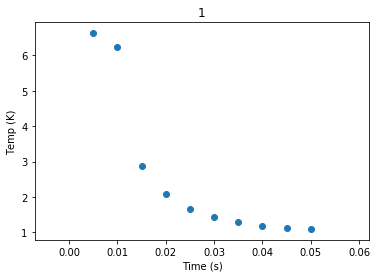

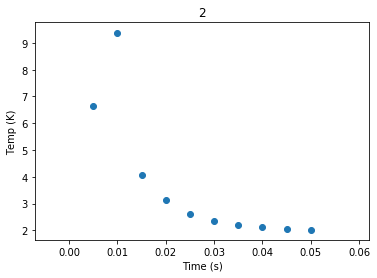

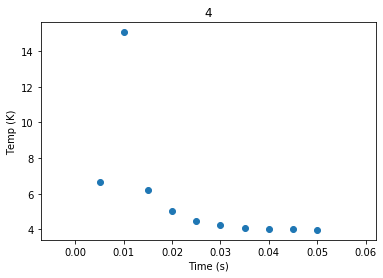

In [10]:
for temp in T_evolution:
    t = (np.arange( len(T_evolution[temp])+1 )[1:])*nsteps*dt
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(t,T_evolution[temp])
    plt.title(str(temp))
    plt.xlabel("Time (s)")
    plt.ylabel("Temp (K)")
    #plt.ylim(temp-0.0001,temp+0.0001)

As seen above, the temperatures relax to the desired values. Note that dt had to be much smaller than the suggested 0.02 or the convergence was too fast to really see

In [11]:
# Part 2
Lx = 8
Ly = 8
dim = 2
N = 12
vmax = 1
dt = 0.02
T_desired = [1,2,4]

outer_steps = 10
nsteps = 100

T_evolution = {}
for T in T_desired:
    system = MDsystem(Lx, Ly, N, dt, BoundaryCondition.PBC)
    system.init(StartConf.Rectangular, vmax )
    T_evolution[T] = []
    
    for i in range(outer_steps):
        
        # Evolve the system nstep number of times
        lump_T = 0
        for j in range(nsteps):
            system.evolve()
            lump_T += system.temperature()
        
        #T_actual = system.temperature()
        T_actual = lump_T/nsteps
        scale_factor = np.sqrt( T/T_actual )
        system.rescale(scale_factor)
    
    # Now we have reached equilibrium
    temps = []
    print(system.temperature())
    for i in range(1000):
        system.evolve()
        temps.append( system.temperature() )
        scale_factor = np.sqrt( T/system.temperature() )
        system.rescale(scale_factor)
    for i in range(len(temps)):
        T_evolution[T].append( np.mean( temps[i:i+5] ) )

1.0372631562396928
2.1222216714176505
3.9343284213483045


As seen below in the plots of temperature fluctuation vs time after relaxation, the fluctuations seem sporadic. Looking at the scale on the y-axis, some of the fluctuations seem a bit larger than I expected, but overall the fluctuations are small and the general temperature stays at the relaxed value.

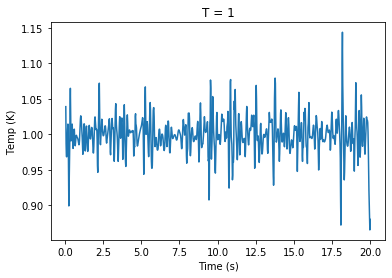

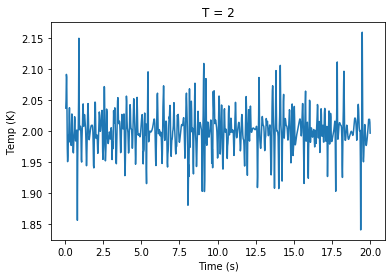

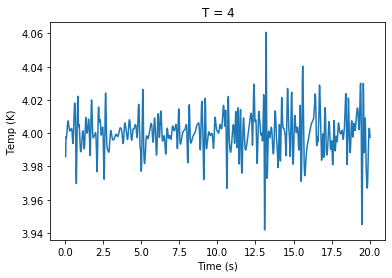

In [12]:
for T in T_evolution:
    hold = np.arange( len(T_evolution[T])+5 )*dt
    times = np.array( [ np.mean( hold[i:i+5] ) for i in range(len(hold)-5) ] )
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times, T_evolution[T])
    plt.title("T = "+str(T))
    plt.xlabel("Time (s)")
    plt.ylabel("Temp (K)")
    plt.show()

Part 3 Plot

As seen, PE and KE have fluctuations throughout, but the total energy remains fairly constant.

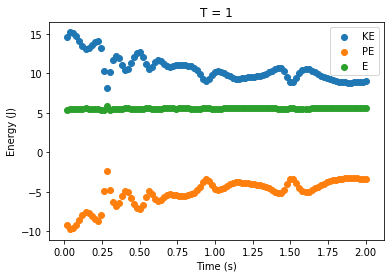

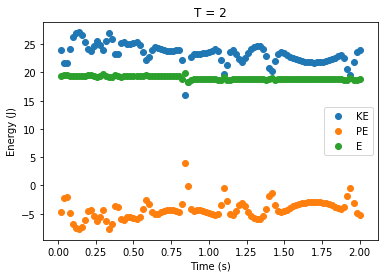

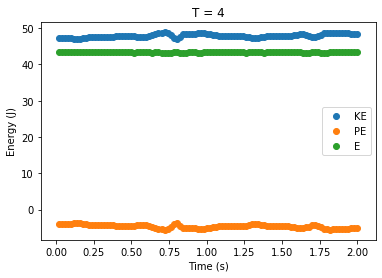

In [13]:
# Part 3
Lx = 8
Ly = 8
dim = 2
N = 12
vmax = 1
dt = 0.02
T_desired = [1,2,4]

outer_steps = 10
nsteps = 100

for T in T_desired:
    system = MDsystem(Lx, Ly, N, dt, BoundaryCondition.PBC)
    system.init(StartConf.Rectangular, vmax )
    KE = []
    PE = []
    E = []
    times = []
    
    for i in range(outer_steps):
        
        # Evolve the system nstep number of times
        lump_T = 0
        for j in range(nsteps):
            system.evolve()
            lump_T += system.temperature()
        
        #T_actual = system.temperature()
        T_actual = lump_T/nsteps
        scale_factor = np.sqrt( T/T_actual )
        system.rescale(scale_factor)
    
    # Now we have reached equilibrium
    for i in range(100):
        system.evolve()
        times.append(dt*(i+1))
        KE.append( system.kinetic_energy() )
        PE.append( system.pot_energy() )
        E.append( system.total_energy() )
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(times,KE,label="KE")
    ax.scatter(times,PE,label="PE")
    ax.scatter(times,E,label="E")
    plt.title("T = "+str(T))
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (J)")
    plt.legend()